In [ ]:
import paddle
import matplotlib.pyplot as plt
import numpy as np
import paddle.nn.functional as F
import paddle.vision.datasets as dset
import paddle
from paddle.vision.transforms import Compose, ToTensor, RandomCrop, RandomHorizontalFlip, Normalize 
from paddle.nn import Sequential, Conv2D, MaxPool2D, Flatten, Linear, BatchNorm2D, Dropout, ReLU
from paddle.io import DataLoader

/opt/conda/envs/python35-paddle120-env/lib/python3.7/site-packages/paddle/fluid/layers/utils.py:26: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  def convert_to_list(value, n, name, dtype=np.int):
/opt/conda/envs/python35-paddle120-env/lib/python3.7/site-packages/matplotlib/__init__.py:107: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated, and in 3.8 it will stop working
  from collections import MutableMapping
/opt/conda/envs/python35-paddle120-env/lib/python3.7/site-packages/matp

In [ ]:
# 加载飞桨内置cifar10数据集
# 转换为tensor格式
transform_train = Compose([
    RandomCrop(32, padding=4),
    RandomHorizontalFlip(),
    ToTensor(),
    Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
])
transform_test = Compose([
    ToTensor(),
    Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
])
# 定义训练集
cifar10_train = dset.Cifar10(
    mode='train',
    transform=transform_train
)
# 定义测试集
cifar10_valid = dset.Cifar10(
    mode='test',
    transform=transform_test
)

Cache file /home/aistudio/.cache/paddle/dataset/cifar/cifar-10-python.tar.gz not found, downloading https://dataset.bj.bcebos.com/cifar/cifar-10-python.tar.gz 
Begin to download

Download finished


In [ ]:
# class Cnet(paddle.nn.Layer):
#     def __init__(self):
#         super(Cnet, self).__init__()
#         # 搭建卷积神经网络
#         self.classify = Sequential(
#             # 卷积层（一）
#             Conv2D(3, 64, 3, 1, 2),  # 卷积操作 [3, 32, 32] -> [64, 34, 34]   
#             BatchNorm2D(64),  # 批归一化
#             ReLU(),  # 激活函数
#             MaxPool2D(2, 2),  # 池化操作 [64, 34, 34] -> [64, 17, 17]
#             # 卷积层（二）
#             Conv2D(64, 128, 3, 1, 2),  # 卷积操作 [64, 17, 17] -> [128, 19, 19]
#             BatchNorm2D(128), 
#             ReLU(), 
#             MaxPool2D(2, 2),  # 池化操作 [128, 19, 19] -> [128, 9, 9]
#             # 卷积层（三）
#             Conv2D(128, 256, 3, 1, 1),  # 卷积操作 [128, 9, 9] -> [256, 9, 9]
#             BatchNorm2D(256), 
#             ReLU(), 
#             MaxPool2D(2, 2),  # 池化操作 [256, 9, 9] -> [256, 4, 4]
#             # 卷积层（四）
#             Conv2D(256, 512, 3, 1, 1),  # 卷积操作 [256, 4, 4] -> [512, 4, 4]
#             BatchNorm2D(512), 
#             ReLU(), 
#             MaxPool2D(2, 2),  # 池化操作 [512, 4, 4] -> [512, 2, 2]
#             # 铺平
#             Flatten(),  # [512, 2, 2] -> [512 * 2 * 2] -> [2048]
#             # 全联接层（一）
#             Linear(2048, 1024),  # [2048] -> [1024]
#             ReLU(),
#             Dropout(p=0.5),  # 正则化
#             # 全联接层（二）
#             Linear(1024,512),  # [1024] -> [512]
#             ReLU(),
#             Dropout(p=0.5),
#             # 全连接层（三）
#             Linear(512,10)  # [512] -> [10]
#         )
#     # 定义神经网络的前向计算过程
#     def forward(self, x):
#         return self.classify(x)
    


In [ ]:
class ResidualBlock(paddle.nn.Layer):
    def __init__(self, inchannel, outchannel, stride=1):
        super(ResidualBlock, self).__init__()
        self.left = Sequential(
            Conv2D(inchannel, outchannel, kernel_size=3, stride=stride, padding=1, bias_attr=False),
            BatchNorm2D(outchannel),
            ReLU(),
            Conv2D(outchannel, outchannel, kernel_size=3, stride=1, padding=1, bias_attr=False),
            BatchNorm2D(outchannel)
        )
        self.shortcut = Sequential()
        if stride != 1 or inchannel != outchannel:
            self.shortcut = Sequential(
                Conv2D(inchannel, outchannel, kernel_size=1, stride=stride, bias_attr=False),
                BatchNorm2D(outchannel)
            )

    def forward(self, x):
        out = self.left(x)
        out += self.shortcut(x)
        out = F.relu(out)
        return out

class ResNet(paddle.nn.Layer):
    def __init__(self, ResidualBlock, num_classes=10):
        super(ResNet, self).__init__()
        self.inchannel = 64
        self.conv1 = Sequential(
            Conv2D(3, 64, kernel_size=3, stride=1, padding=1, bias_attr=False),
            BatchNorm2D(64),
            ReLU(),
        )
        self.layer1 = self.make_layer(ResidualBlock, 64,  2, stride=1)
        self.layer2 = self.make_layer(ResidualBlock, 128, 2, stride=2)
        self.layer3 = self.make_layer(ResidualBlock, 256, 2, stride=2)
        self.layer4 = self.make_layer(ResidualBlock, 512, 2, stride=2)
        self.fc = Linear(512, num_classes)

    def make_layer(self, block, channels, num_blocks, stride):
        strides = [stride] + [1] * (num_blocks - 1)   
        layers = []
        for stride in strides:
            layers.append(block(self.inchannel, channels, stride))
            self.inchannel = channels
        return Sequential(*layers)

    def forward(self, x):
        out = self.conv1(x)
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = F.avg_pool2d(out, 4)
        out = paddle.reshape(out, [out.shape[0], -1])
        out = self.fc(out)
        return out

def ResNet18():
    return ResNet(ResidualBlock)

In [ ]:
model = ResNet18()
paddle.summary(model, (1, 3, 32, 32))

---------------------------------------------------------------------------
 Layer (type)       Input Shape          Output Shape         Param #    
   Conv2D-1       [[1, 3, 32, 32]]     [1, 64, 32, 32]         1,728     
 BatchNorm2D-1   [[1, 64, 32, 32]]     [1, 64, 32, 32]          256      
    ReLU-1       [[1, 64, 32, 32]]     [1, 64, 32, 32]           0       
   Conv2D-2      [[1, 64, 32, 32]]     [1, 64, 32, 32]        36,864     
 BatchNorm2D-2   [[1, 64, 32, 32]]     [1, 64, 32, 32]          256      
    ReLU-2       [[1, 64, 32, 32]]     [1, 64, 32, 32]           0       
   Conv2D-3      [[1, 64, 32, 32]]     [1, 64, 32, 32]        36,864     
 BatchNorm2D-3   [[1, 64, 32, 32]]     [1, 64, 32, 32]          256      
ResidualBlock-1  [[1, 64, 32, 32]]     [1, 64, 32, 32]           0       
   Conv2D-4      [[1, 64, 32, 32]]     [1, 64, 32, 32]        36,864     
 BatchNorm2D-4   [[1, 64, 32, 32]]     [1, 64, 32, 32]          256      
    ReLU-3       [[1, 64, 32, 32]]  

{'total_params': 11183562, 'trainable_params': 11164362}

In [8]:
# 训练模型 

# 设置训练轮数
epochs = 10
# 设置批次数
bats = 256
# 用于存放accuracy的list
val_acc = []
# 用于存放loss的list
val_loss = []

def train(model):
    use_gpu = True
    paddle.set_device('gpu:0') if use_gpu else paddle.set_device('cpu')
    print('start training ... ')
    model.train()
    # 定义Adam优化器
    opt = paddle.optimizer.Adam(
        learning_rate=0.0001,
        parameters=model.parameters()
    )
    # 训练集加载器
    train_loader = DataLoader(
        cifar10_train,
        shuffle=True,
        batch_size=bats
    )
    # 验证集加载器
    valid_loader = DataLoader(
        cifar10_valid, 
        batch_size=bats
    )
    # 开始训练
    for epoch in range(epochs):
        for data in train_loader():
            # 存放图像数据
            x_data = data[0] 
            # 存放图像label，转换为tensor
            y_data = paddle.to_tensor(data[1])
            y_data = paddle.unsqueeze(y_data, 1)
            # 训练预测结果
            logits = model(x_data)
            # softmax交叉熵损失函数
            loss = F.cross_entropy(logits, y_data)
            loss.backward()
            opt.step()
            opt.clear_grad()

        # 模型评估
        model.eval()
        accuracies = []
        losses = []
        for data in valid_loader():
            x_data = data[0]
            y_data = paddle.to_tensor(data[1])
            y_data = paddle.unsqueeze(y_data, 1)

            logits = model(x_data)
            loss = F.cross_entropy(logits, y_data)
            acc = paddle.metric.accuracy(logits, y_data)
            accuracies.append(acc.numpy())
            losses.append(loss.numpy())

        avg_acc, avg_loss = np.mean(accuracies), np.mean(losses)
        print("epoch{} accuracy: {} loss: {}".format(epoch, avg_acc, avg_loss))
        val_acc.append(avg_acc)
        val_loss.append(avg_loss)
        model.train()
        # 保存模型参数
        paddle.save(model.state_dict(), 'weight/param.pdparams')

In [9]:
# 读取训练好的模型参数，需要重新训练注释掉下两行即可
model_state_dict = paddle.load('weight/param.pdparams')
model.load_dict(model_state_dict)
train(model)

start training ... 
epoch0 accuracy: 0.921679675579071 loss: 0.49973711371421814
epoch1 accuracy: 0.926953136920929 loss: 0.45721548795700073
epoch2 accuracy: 0.925585925579071 loss: 0.49057644605636597
epoch3 accuracy: 0.9283202886581421 loss: 0.4752563536167145
epoch4 accuracy: 0.9288085699081421 loss: 0.4636281430721283
epoch5 accuracy: 0.9312499761581421 loss: 0.46264395117759705
epoch6 accuracy: 0.925585925579071 loss: 0.4772551655769348
epoch7 accuracy: 0.927929699420929 loss: 0.4732561707496643
epoch8 accuracy: 0.927050769329071 loss: 0.47660940885543823
epoch9 accuracy: 0.9278320074081421 loss: 0.4931873381137848


/opt/conda/envs/python35-paddle120-env/lib/python3.7/site-packages/matplotlib/cbook/__init__.py:2349: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated, and in 3.8 it will stop working
  if isinstance(obj, collections.Iterator):
/opt/conda/envs/python35-paddle120-env/lib/python3.7/site-packages/matplotlib/cbook/__init__.py:2366: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated, and in 3.8 it will stop working
  return list(data) if isinstance(data, collections.MappingView) else data


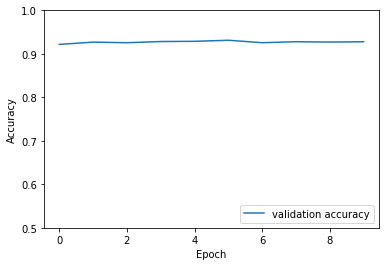

In [10]:
# 可视化
plt.plot(val_acc, label = 'validation accuracy')

plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.5, 1.0])
plt.legend(loc='lower right')

In [ ]:
# 查看当前挂载的数据集目录, 该目录下的变更重启环境后会自动还原
# View dataset directory. 
# This directory will be recovered automatically after resetting environment. 
!ls /home/aistudio/data

In [ ]:
# 查看工作区文件, 该目录下的变更将会持久保存. 请及时清理不必要的文件, 避免加载过慢.
# View personal work directory. 
# All changes under this directory will be kept even after reset. 
# Please clean unnecessary files in time to speed up environment loading. 
!ls /home/aistudio/work

In [ ]:
# 如果需要进行持久化安装, 需要使用持久化路径, 如下方代码示例:
# If a persistence installation is required, 
# you need to use the persistence path as the following: 
!mkdir /home/aistudio/external-libraries
!pip install beautifulsoup4 -t /home/aistudio/external-libraries

In [ ]:
# 同时添加如下代码, 这样每次环境(kernel)启动的时候只要运行下方代码即可: 
# Also add the following code, 
# so that every time the environment (kernel) starts, 
# just run the following code: 
import sys 
sys.path.append('/home/aistudio/external-libraries')

请点击[此处](https://ai.baidu.com/docs#/AIStudio_Project_Notebook/a38e5576)查看本环境基本用法.  <br>
Please click [here ](https://ai.baidu.com/docs#/AIStudio_Project_Notebook/a38e5576) for more detailed instructions. 